# Implementation of Multilayer Perceptrons from Scratch
:label:`sec_mlp_scratch`

Now that we have characterized
multilayer perceptrons (MLPs) mathematically,
let us try to implement one ourselves. To compare against our previous results
achieved with softmax regression
(:numref:`sec_softmax_scratch`),
we will continue to work with
the Fashion-MNIST image classification dataset
(:numref:`sec_fashion_mnist`).


In [1]:
!pip install d2l

In [2]:
from d2l import tensorflow as d2l
import tensorflow as tf

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Utilities

In [4]:
# Defined in file: ./chapter_linear-networks/linear-regression-scratch.md
def sgd(params, grads, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)


In [5]:
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Updater():  
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        sgd(self.params, grads, self.lr, batch_size)


In [6]:
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train_epoch_ch3(net, train_iter, loss, updater):  
    """The training loop defined in Chapter 3."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, d2l.accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]



In [7]:
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model (defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc



In [8]:
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def predict_ch3(net, test_iter, n=6): 
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(d2l.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(d2l.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])



## Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
Again, we will disregard the spatial structure
among the pixels for now,
so we can think of this as simply a classification dataset
with 784 input features and 10 classes.
To begin, we will implement an MLP
with one hidden layer and 256 hidden units.
Note that we can regard both of these quantities
as hyperparameters.
Typically, we choose layer widths in powers of 2,
which tend to be computationally efficient because
of how memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In [9]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = tf.Variable(tf.random.normal(
    shape=(num_inputs, num_hiddens), mean=0, stddev=0.01))
b1 = tf.Variable(tf.zeros(num_hiddens))
W2 = tf.Variable(tf.random.normal(
    shape=(num_hiddens, num_outputs), mean=0, stddev=0.01))
b2 = tf.Variable(tf.random.normal([num_outputs], stddev=.01))

params = [W1, b1, W2, b2]

## Activation Function

To make sure we know how everything works,
we will implement the ReLU activation ourselves
using the maximum function rather than
invoking the built-in `relu` function directly.


In [10]:
def relu(X):
    return tf.math.maximum(X, 0)

## Model

Because we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we implement our model
with just a few lines of code.


In [11]:
def net(X):
    X = tf.reshape(X, (-1, num_inputs))
    H = relu(tf.matmul(X, W1) + b1)
    return tf.matmul(H, W2) + b2

## Loss Function

To ensure numerical stability,
and because we already implemented
the softmax function from scratch
(:numref:`sec_softmax_scratch`),
we leverage the integrated function from high-level APIs
for calculating the softmax and cross-entropy loss.
Recall our earlier discussion of these intricacies
in :numref:`subsec_softmax-implementation-revisited`.
We encourage the interested reader
to examine the source code for the loss function
to deepen their knowledge of implementation details.


In [32]:
def loss(y_hat, y):
    return tf.losses.sparse_categorical_crossentropy(
        y, y_hat, from_logits=True)

Now we can implement the cross-entropy loss function efficiently with just one line of code.

In [13]:
def cross_entropy_loss(y_hat, y):
    return -tf.math.log(
        tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))



In [37]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
yl=tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))
print(yl)
print(loss(y_hat, y))

print(cross_entropy_loss(y_hat, y))

tf.Tensor([0.1 0.5], shape=(2,), dtype=float32)
tf.Tensor([1.3532865 0.939831 ], shape=(2,), dtype=float32)
tf.Tensor([2.3025851 0.6931472], shape=(2,), dtype=float32)


## Training

Fortunately, the training loop for MLPs
is exactly the same as for softmax regression.
Leveraging the `d2l` package again,
we call the `train_ch3` function
(see :numref:`sec_softmax_scratch`),
setting the number of epochs to 10
and the learning rate to 0.5.


AssertionError: ignored

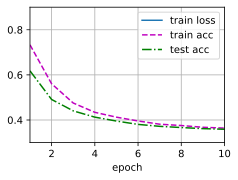

In [25]:
num_epochs, lr = 10, 0.1
updater = Updater([W1, W2, b1, b2], lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

To evaluate the learned model,
we apply it on some test data.


In [ ]:
predict_ch3(net, test_iter)

## Summary

* We saw that implementing a simple MLP is easy, even when done manually.
* However, with a large number of layers, implementing MLPs from scratch can still get messy (e.g., naming and keeping track of our model's parameters).


## Exercises

1. Change the value of the hyperparameter `num_hiddens` and see how this hyperparameter influences your results. Determine the best value of this hyperparameter, keeping all others constant.
1. Try adding an additional hidden layer to see how it affects the results.
1. How does changing the learning rate alter your results? Fixing the model architecture and other hyperparameters (including number of epochs), what learning rate gives you the best results?
1. What is the best result you can get by optimizing over all the hyperparameters (learning rate, number of epochs, number of hidden layers, number of hidden units per layer) jointly?
1. Describe why it is much more challenging to deal with multiple hyperparameters.
1. What is the smartest strategy you can think of for structuring a search over multiple hyperparameters?


[Discussions](https://discuss.d2l.ai/t/227)
